# Predicting Fake News - Final Report
The dataset is about fake news articles; the name of the author, the title of the article, the text of the article and whether it is fake or real is included in this dataset. It can be found on Kaggle:
https://www.kaggle.com/c/fake-news/data

Disclaimer: The dataset above is simulated

### Business Problem:
A popular social media company has hired us to investigate fake news article and develop models that can flag articles that are fake so they can be removed from their platform and not propogate misinformation. These news articles are polarizing people on their platform and the effects are pouring over into everyday life. They want to let their users know which articles are fake by flagging them or removing them altogther. Customers are swithcing to competitor platforms where this problem has already been handled. 

### Client
Social Media Company 

### Objective
My objective is to gain insight into what features fake news articles consist of and if they can be distinguished. The ultimate goal is to create models that can accurately predict if an article is fake or not. 

Overview of Analytical Pipeline
This project follows a typical data science pipeline.

1. First approach in solving the problem is obtaining the relevant data.
2. Cleaning the data is the next step. This includes checking for null values, imputing missing values and checking column names
3. Next, we explore the data to gain insights into our dataset and what it contains. This includes looking for outliers or unusual data as well as using a correlation matrix to understand the relationship between the response and predictor variables.
4. Modeling using Machine Learning gives us our predictive power on whether the bank will lose a customer or not.
5. Lastly, we interpret the results and see what can we conlcude about bank customers leaving the bank. For example, what feature variable was most indicative of customers leaving the bank?

# 1. Obtaining the Data
---

In [234]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.stats as stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)


In [190]:
df = pd.read_csv('train.csv')

In [191]:
print(df.shape)
df.head(5)

(20800, 5)


id                                              title              author  \
0   0  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [192]:
# Checking if dataset labels are balanced 
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

# 2. Cleaning the Data
---

- change title to article_title --
- missing values in all columns -- 
- drops rows with missing text columns -- 
- drop rows underneath a certain text limit (length(text)) --
- Replace null values in title and author to 'Unknown' -- 
- Either make the id column the index column or drop it --
- Check author names for same names with minor variations 

In [193]:
# change title to article_title
df.rename(columns={"title": "article_title"}, inplace=True)
df.head()

id                                      article_title              author  \
0   0  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [194]:
# drop id column 
df.drop('id', axis=1, inplace=True)

For visual purposes, I like to move the response variable, in this case 'Exited', to the left side of the table. I find it quicker to view it this way, and also makes the dataset splitting into train/test set easier later on.

In [195]:
first_column = df['label']
df.drop('label', axis=1,inplace=True)
df.insert(0, 'label', first_column)
df.head()

label                                      article_title  \
0      1  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2      1                  Why the Truth Might Get You Fired   
3      1  15 Civilians Killed In Single US Airstrike Hav...   
4      1  Iranian woman jailed for fictional unpublished...   

               author                                               text  
0       Darrell Lucus  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...  
1     Daniel J. Flynn  Ever get the feeling your life circles the rou...  
2  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...  
3     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...  
4      Howard Portnoy  Print \nAn Iranian woman has been sentenced to...

In [196]:
df.dtypes

label             int64
article_title    object
author           object
text             object
dtype: object

In [213]:
# helper function to get length of text entries
def findlength(dataframe, column_name):
    try:
        hold = [len(str(words)) for words in df[column_name]]
    except: 
        print('Check datatype or column name.')
    return hold

# helper function to plot null counts in each dataset column
def null_plot(df, kind):
    null_df = pd.DataFrame(columns=['column_name', 'null_counts'])
    null_df['column_name'] = df.columns
    null_df['null_counts'] = df.isnull().sum().values
    #df.isnull().sum().values
    null_df.sort_values(by=['null_counts'], ascending=True, inplace=True)
    null_df.plot(x='column_name', y='null_counts', kind=kind)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    print(df.isnull().sum().sort_values(ascending=False))
    plt.show()
    
    

# helper function for text preprocessing
def preprocess(article_text):
    article_text = article_text.str.replace("(<br/>)", "")
    article_text = article_text.str.replace("(\n)", "")
    article_text = article_text.str.replace('(<a).*(>).*(</a>)', '')
    article_text = article_text.str.replace('(&amp)', '')
    article_text = article_text.str.replace('(&gt)', '')
    article_text = article_text.str.replace('(&lt)', '')
    article_text = article_text.str.replace('(\xa0)', ' ')  
    # Remove Emails
    article_text = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in article_text]

    # Remove new line characters
    article_text = [re.sub('\s+', ' ', sent) for sent in article_text]

    # Remove distracting single quotes
    article_text = [re.sub("\'", "", sent) for sent in article_text]
    return article_text

def dist_plot(df, column, title, article_type):
    plt.figure(figsize=(12,6))
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    sns.set_context("paper")
    sns.distplot(df[column], bins=35,hist=True)
    plt.title(title)
    real_tpmean = df[column].mean()
    real_tpmedian = df[column].median()
    print('The mean of text polarity in ' + article_type + ' is: ' + str(round(real_tpmean,3)))
    print('The median of text polarity in ' + article_type + ' is: ' + str(round(real_tpmedian,3)))
    plt.axvline(real_tpmean, color='r',alpha=0.5)
    plt.axvline(real_tpmedian, color='g',alpha=0.8)
    plt.show()
    
# Function to get top N_words
""" Following three functions were sourced from 
https://github.com/susanli2016/NLP-with-Python/blob/master/EDA%20and%20visualization%20for%20Text%20Data.ipynb"""

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_words_nosw(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram_nosw(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram_nosw(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [198]:
df['text'] = preprocess(df['text'])

In [199]:
df['length'] = findlength(df, 'text')
df.head()

label                                      article_title  \
0      1  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2      1                  Why the Truth Might Get You Fired   
3      1  15 Civilians Killed In Single US Airstrike Hav...   
4      1  Iranian woman jailed for fictional unpublished...   

               author                                               text  \
0       Darrell Lucus  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...   
1     Daniel J. Flynn  Ever get the feeling your life circles the rou...   
2  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...   
3     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...   
4      Howard Portnoy  Print An Iranian woman has been sentenced to s...   

   length  
0    4886  
1    4143  
2    7670  
3    3223  
4     934

In [200]:
df[df['length'] < 50]

label                                      article_title  \
82         1                         Huma‚Äôs Weiner Dogs Hillary   
142        1  Gorafi Magazine : Entretien exclusif avec Bara...   
169        1  Mohamad Khweis: Another ‚ÄúVirginia Man‚Äù (Palest...   
173        1  Trump family already ‚Äòsworn to secrecy‚Äô about ...   
196        1                                                NaN   
295        1  A Connecticut Reader Reports Record Voter Regi...   
470        1  BULLETIN: There ARE Righteous Jews For Trump!;...   
485        1                       Calgary Airport Arrivals YYC   
573        1  Le top des recherches Google passe en top des ...   
580        1                                                NaN   
592        1  Is your promising internet career over now Vin...   
786        1                                                NaN   
871        1  ‚ÄúDonald Trump And The Rise Of White Identity I...   
901        1                                   Internet Flasher   
936        1  Hillary is Sick & Tired of Suffering from Wein...   
950        1  NATIONAL REVIEW, Conservatism Inc., Plan To Ca...   
1002       1  Siri Can Open Smart Locks and Let Neighbors Wa...   
1031       1                                                NaN   
1073       1                                                NaN   
1200       1  La Cor√©e du Nord annonce avoir envoy√© un missi...   
1453       1                                                NaN   
1485       1                                                NaN   
1591       1  More on Trump‚Äôs Populism and How It Can Be Con...   
1911       1  Grand-Prix du Br√©sil ‚Äì Romain Grosjean obtient...   
1942       1                                                NaN   
1985       1                                                NaN   
2144       1                                                NaN   
2148       1  Gorafi Magazine: Barack Obama ¬´ Je vous ai d√©j...   
2163       1            John Derbyshire On Peter Thiel On Trump   
2169       1  #NDDL: Pour f√™ter l‚Äôautorisation des travaux, ...   
2228       1  YIKES! HILLARY GOES OFF THE RAILS‚Ä¶Pulls A Howa...   
2298       1  Confusion as Clinton Cards changes name to Tru...   
2347       1                                                NaN   
2382       1                                 Who Was Marc Rich?   
2647       1               Of Veterans and Black Mirror Roaches   
2684       1  MARKETWATCH LEFTIST: MSM‚Äôs ‚ÄúBlatant‚Äù Anti Trum...   
2712       1                                                NaN   
2793       1  ¬´Pourquoi je suis candidat √† la pr√©sidentielle...   
2854       1                                                NaN   
2896       1                                                NaN   
3319       1  BP Earthwatch: AURORAS PENETRATING DEEP INTO E...   
3322       1  President of South Korea Is a Puppet of Her Ra...   
3329       1  GuinessBook : 100 millions d‚ÄôAm√©ricains batten...   
3385       1                                                NaN   
3499       1                                                NaN   
3729       1  Les Am√©ricains ne sont plus qu‚Äô√† quelques heur...   
3784       1                                                NaN   
3834       1  Hillary IMPLODES: Trump 'Took Everything...Pai...   
3848       1  ‚ÄòArab Spring‚Äô and the Washington-Brussels-Riya...   
3900       1                                                NaN   
3904       1                                                NaN   
3957       1                  NYT: Whites Must Know Their Place   
4234       1                                                NaN   
4275       1  Yes, Virginia (Dare), There ARE Righteous Jews...   
4288       1            Hillary Clinton en 5 dates >> Le Gorafi   
4340       1                                                NaN   
4358       1  Ne supportant plus l‚Äôambiance de la campagne √©...   
4398       1  Adele helps pregnant mothers by telling them; ...   
4710 

author           1957
article_title     558
length              0
text                0
label               0
dtype: int64


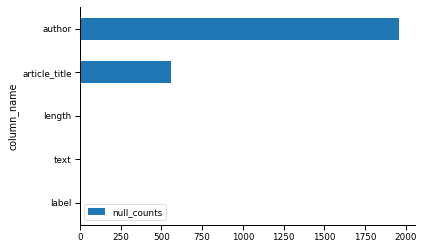

In [203]:
null_plot(df,'barh')

In [205]:
# Replace Null Values in author and title to Unknown
values = {'author' : 'Unknown', 'article_title': 'Unknown'}
df.fillna(value=values, inplace=True)

text_polarity    0
length           0
text             0
author           0
article_title    0
label            0
dtype: int64


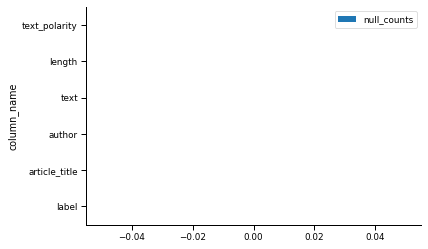

In [236]:
null_plot(df,'barh')

In [206]:
df['author'].value_counts().head(5)

Unknown             1957
Pam Key              243
admin                193
Jerome Hudson        166
Charlie Spiering     141
Name: author, dtype: int64

In [207]:
# Drop rows that have article length less than 50 characters
df.drop(df[df['length'] < 50].index, inplace = True) 

In [208]:
print(df.shape)
df.head(5)

(20554, 5)


label                                      article_title  \
0      1  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2      1                  Why the Truth Might Get You Fired   
3      1  15 Civilians Killed In Single US Airstrike Hav...   
4      1  Iranian woman jailed for fictional unpublished...   

               author                                               text  \
0       Darrell Lucus  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...   
1     Daniel J. Flynn  Ever get the feeling your life circles the rou...   
2  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...   
3     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...   
4      Howard Portnoy  Print An Iranian woman has been sentenced to s...   

   length  
0    4886  
1    4143  
2    7670  
3    3223  
4     934

# 3. Exploring the Data
---
- Topics to review:
- Bag of words
- countvectorizer
- tfidf 
- topic modeling 

----
- Add sentiment column using TextBlob --
- draw distribution plot of sentiment -- 
- draw distribution plot of real article sentiments -- 
- draw distribution plot of fake article sentiments -- 
- draw bar plot of mean sentiment score of real & fake articles
- draw heatmap showing correlations 
- compare uni, bi and tri-gram word_vectors top features with and without removing stop-words

In [209]:
# Added text_polarity column. contains polarity of text on scale -1 to 1 indicating -ve to +ve.
df['text_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [210]:
df.head()

label                                      article_title  \
0      1  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2      1                  Why the Truth Might Get You Fired   
3      1  15 Civilians Killed In Single US Airstrike Hav...   
4      1  Iranian woman jailed for fictional unpublished...   

               author                                               text  \
0       Darrell Lucus  House Dem Aide: We Didn‚Äôt Even See Comey‚Äôs Let...   
1     Daniel J. Flynn  Ever get the feeling your life circles the rou...   
2  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...   
3     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...   
4      Howard Portnoy  Print An Iranian woman has been sentenced to s...   

   length  text_polarity  
0    4886       0.001796  
1    4143       0.100880  
2    7670       0.056258  
3    3223       0.017497  
4     934      -0.012500

In [211]:
# Created two dataframes, one with +ve text polarity data and another with -ve text polarity data
neg_tp = df[df['text_polarity'] < 0]
pos_tp = df[df['text_polarity'] > 0]

In [212]:
# Created two dataframes, one with all fake labels data and another with real labels data
fake_df = df[df['label'] == 0]
real_df = df[df['label'] == 1]

The mean of text polarity in all articles is: 0.071
The median of text polarity in all articles is: 0.071


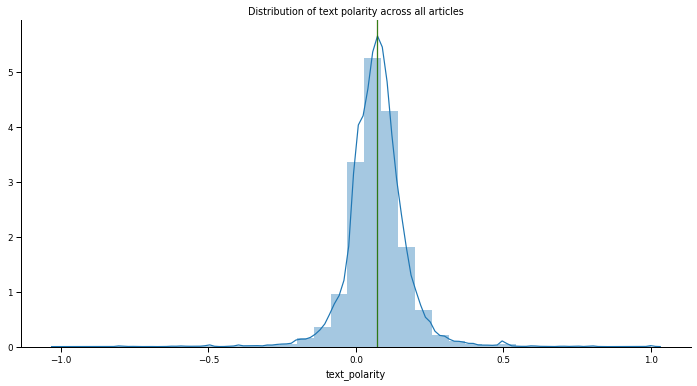

In [214]:
dist_plot(df, 'text_polarity', 'Distribution of text polarity across all articles', 'all articles')

The mean of text polarity in real articles is: 0.069
The median of text polarity in real articles is: 0.065


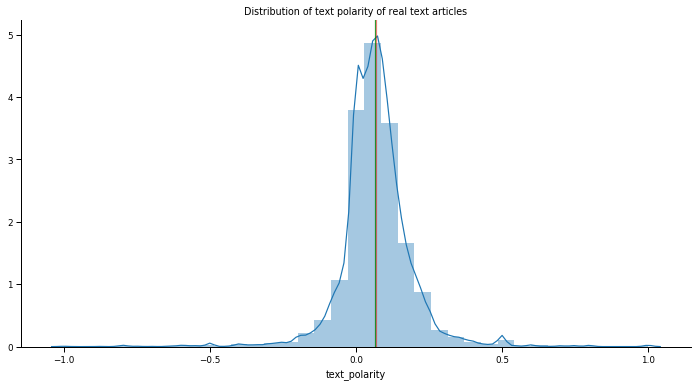

In [215]:
# Distribution of text_polarity of real text articles
# Overall real text articles seem to have neutral polarity 
dist_plot(real_df, 'text_polarity', 'Distribution of text polarity of real text articles', 'real articles')

The mean of text polarity in fake articles is: 0.074
The median of text polarity in fake articles is: 0.075


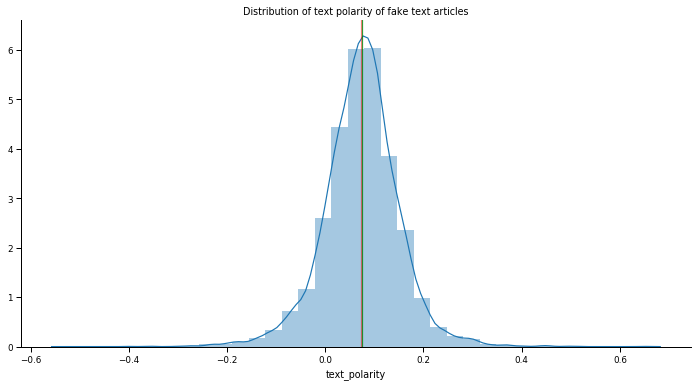

In [216]:
# Distribution of text_polarity of fake text articles
# Overall fake text articles seem to have neutral polarity 
dist_plot(fake_df, 'text_polarity', 'Distribution of text polarity of fake text articles', 'fake articles')

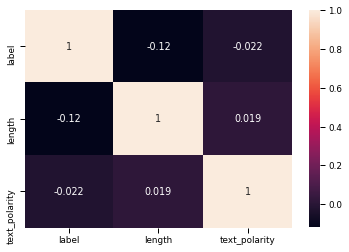

In [237]:
# Create a heatmap 
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

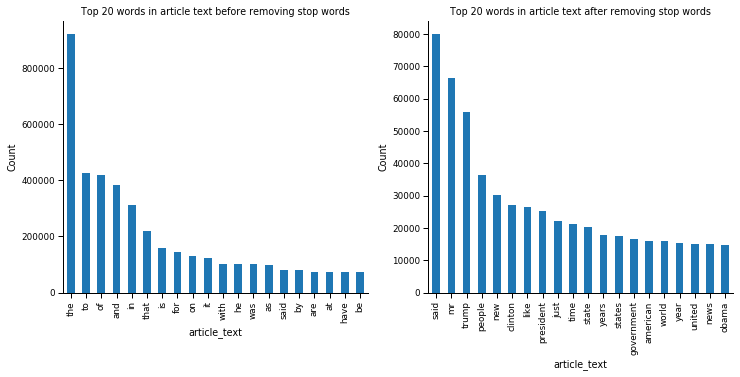

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top unigrams before removing stop words (sw)

uni_words_sw = get_top_n_words(df['text'], 20)

df1 = pd.DataFrame(uni_words_sw, columns=['article_text', 'count'])
df1.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in article text before removing stop words', ax=ax1)
ax1.set(ylabel='Count')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Top unigrams after removing stop words
uni_words_no_sw = get_top_n_words_nosw(df['text'], 20)

df2 = pd.DataFrame(uni_words_no_sw, columns=['article_text', 'count'])
ax2.set(ylabel='Count')
df2.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in article text after removing stop words', ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

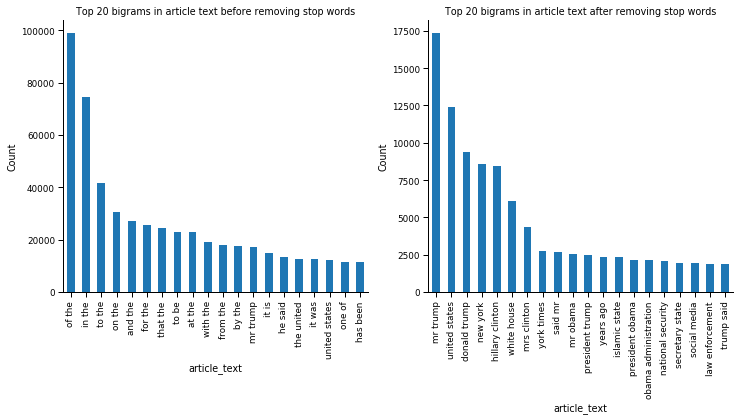

In [220]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top bigrams before removing stop words

bi_words_sw = get_top_n_bigram(df['text'], 20)

df3 = pd.DataFrame(bi_words_sw, columns=['article_text', 'count'])
df3.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top bigrams after removing stop words
bi_words_nosw = get_top_n_bigram_nosw(df['text'], 20)

df4 = pd.DataFrame(bi_words_nosw, columns=['article_text', 'count'])
df4.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

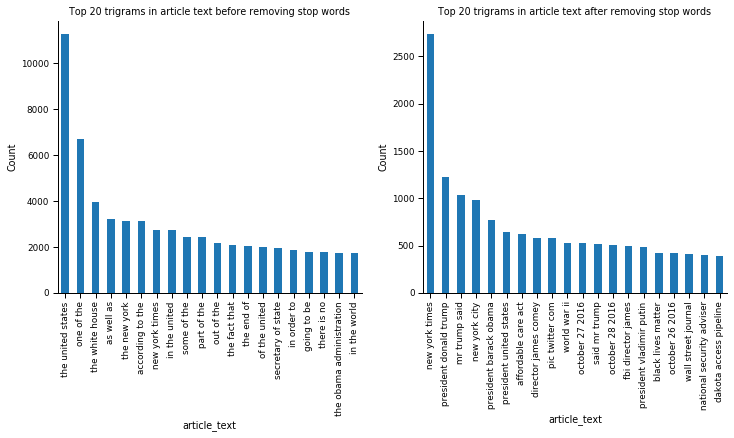

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top trigrams before removing stop words

tri_words_sw = get_top_n_trigram(df['text'], 20)

df5 = pd.DataFrame(tri_words_sw, columns=['article_text', 'count'])
df5.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top trigrams after removing stop words
tri_words_nosw = get_top_n_trigram_nosw(df['text'], 20)

df6 = pd.DataFrame(tri_words_nosw, columns=['article_text', 'count'])
df6.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

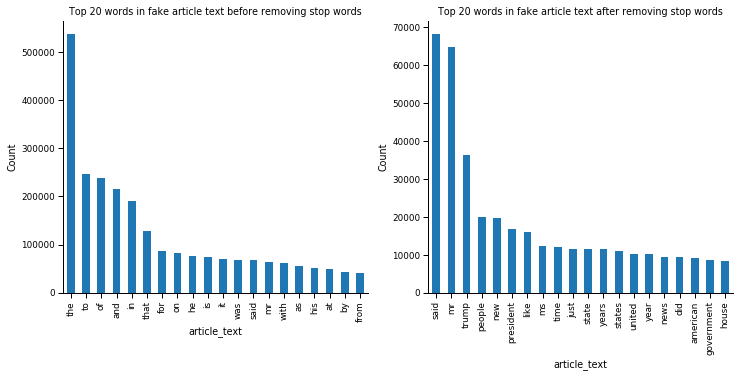

In [221]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top unigrams before removing stop words (sw) in fake articles' text 

fake_uni_words_sw = get_top_n_words(fake_df['text'], 20)

df_fake_1 = pd.DataFrame(fake_uni_words_sw, columns=['article_text', 'count'])
df_fake_1.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in fake article text before removing stop words', ax=ax1)

ax1.set(ylabel='Count')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# Top unigrams after removing stop words (sw) in fake articles' text 
fake_uni_words_no_sw = get_top_n_words_nosw(fake_df['text'], 20)

df_fake_2 = pd.DataFrame(fake_uni_words_no_sw, columns=['article_text', 'count'])
df_fake_2.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in fake article text after removing stop words', ax=ax2)
ax2.set(ylabel='Count')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

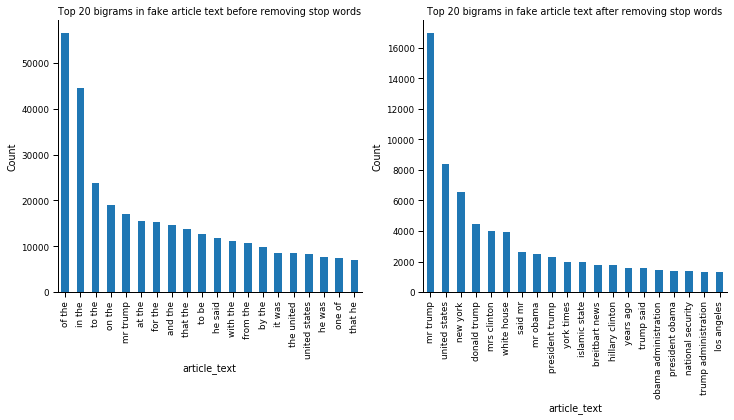

In [222]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top bigrams before removing stop words

fake_bi_words_sw = get_top_n_bigram(fake_df['text'], 20)

df_fake_3 = pd.DataFrame(fake_bi_words_sw, columns=['article_text', 'count'])
df_fake_3.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in fake article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top bigrams after removing stop words
fake_bi_words_nosw = get_top_n_bigram_nosw(fake_df['text'], 20)

df_fake_4 = pd.DataFrame(fake_bi_words_nosw, columns=['article_text', 'count'])
df_fake_4.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in fake article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

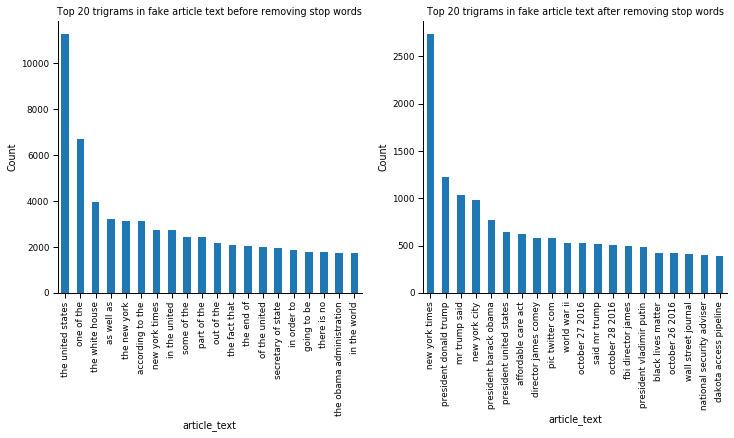

In [223]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top trigrams before removing stop words

fake_tri_words_sw = get_top_n_trigram(df['text'], 20)

df_fake_5 = pd.DataFrame(fake_tri_words_sw, columns=['article_text', 'count'])
df_fake_5.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in fake article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top trigrams after removing stop words
fake_tri_words_nosw = get_top_n_trigram_nosw(df['text'], 20)

df_fake_6 = pd.DataFrame(fake_tri_words_nosw, columns=['article_text', 'count'])
df_fake_6.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in fake article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

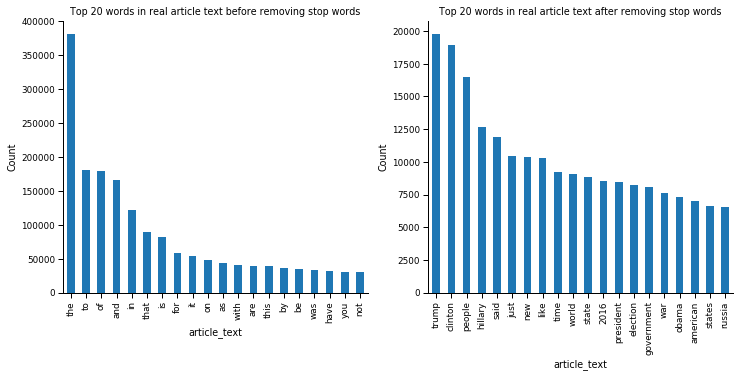

In [224]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top unigrams before removing stop words (sw) in real articles' text 

real_uni_words_sw = get_top_n_words(real_df['text'], 20)

df_real_1 = pd.DataFrame(real_uni_words_sw, columns=['article_text', 'count'])
df_real_1.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in real article text before removing stop words', ax=ax1)
ax1.set(ylabel='Count')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Top unigrams after removing stop words (sw) in real articles' text 
real_uni_words_no_sw = get_top_n_words_nosw(real_df['text'], 20)

df_real_2 = pd.DataFrame(real_uni_words_no_sw, columns=['article_text', 'count'])
df_real_2.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in real article text after removing stop words', ax=ax2)
ax2.set(ylabel='Count')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

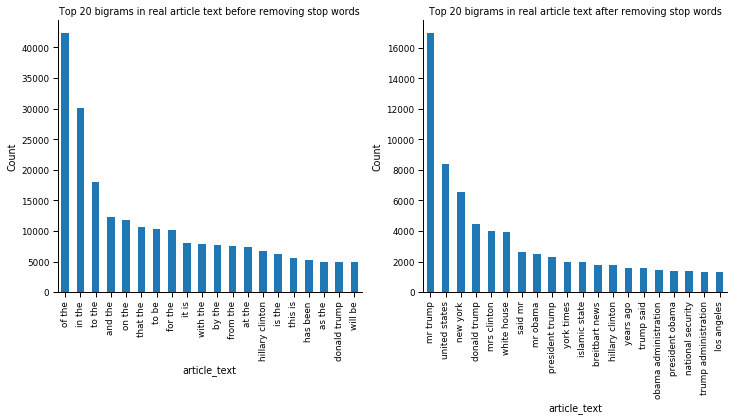

In [225]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top bigrams before removing stop words in real articles' text

real_bi_words_sw = get_top_n_bigram(real_df['text'], 20)

df_real_3 = pd.DataFrame(real_bi_words_sw, columns=['article_text', 'count'])
df_real_3.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in real article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top bigrams after removing stop words in real articles' text

real_bi_words_nosw = get_top_n_bigram_nosw(fake_df['text'], 20)

df_fake_4 = pd.DataFrame(real_bi_words_nosw, columns=['article_text', 'count'])
df_fake_4.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in real article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

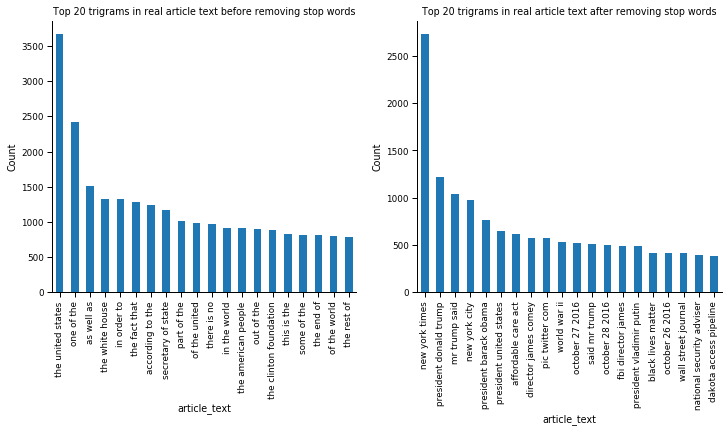

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top trigrams before removing stop words in real articles' text

real_tri_words_sw = get_top_n_trigram(real_df['text'], 20)

df_real_5 = pd.DataFrame(real_tri_words_sw, columns=['article_text', 'count'])
df_real_5.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in real article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top trigrams after removing stop words in real articles' text
real_tri_words_nosw = get_top_n_trigram_nosw(df['text'], 20)

df_real_6 = pd.DataFrame(real_tri_words_nosw, columns=['article_text', 'count'])
df_real_6.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in real article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

# T-Test
### A t-test is a type of inferential statistic used to determine if there is a significant difference between the means of two groups, which may be related in certain features.

# One Sample T-Test

A one-sample t-test is used to test whether a population mean is significantly different from some hypothesized value. We are going to test to see whether the average text polarity of fake articles differs from the average text polarity of all articles. 

Hypothesis Testing: Is there significant difference in the means of text polarity between articles that are fake and all text articles?

**Null Hypothesis:** The null hypothesis would be there there is no difference in text polarity between articles that are fake and all text articles. 

**Alternate Hypothesis:** The alternative hypothesis would be that there is a difference in text polarity between fake articles and all articles 

In [227]:
# Look at the means of the credit score of customers who exited and all bank customers 
mean_all_articles  =   df['text_polarity'].mean()
mean_fake_articles = fake_df['text_polarity'].mean()

print('The mean text polarity of all articles is ' + str(mean_all_articles))
print('The mean text polarity of fake articles is ' + str(mean_fake_articles))

The mean text polarity of all articles is 0.07129251085549954
The mean text polarity of fake articles is 0.0735741624574898


## Conduct the T-Test

Let's conduct a t-test at 95% confidence interval and see if the null hypothesis (sample comes from the same distribution as all articles population) is correctly rejected. We can conduct a one sample t-test using the stats.ttest_1samp() function:

In [229]:
stats.ttest_1samp(a=  fake_df['text_polarity'], # Sample of text polarity ofarticles that are fake 
                  popmean = mean_all_articles) # Mean of the population

Ttest_1sampResult(statistic=3.020018793001539, pvalue=0.0025337349388929752)

The test result shows the test statistic 't' is equal to 3.0200. T is simply the calculated difference represented in units of standard error and tells us how much the sample mean deviates from the null hypothesis. We can reject the null hypothesis if the t-statistic lies outside the quantiles of the t-distribution corresponding to our confidence level and degrees of freedom. We can check the quantiles with stats.t.ppf():

T is simply the calculated difference represented in units of standard error. The greater the magnitude of T, the greater the evidence against the null hypothesis. This means there is greater evidence that there is a significant difference. The closer T is to 0, the more likely there isn't a significant difference.

In [232]:
degree_of_freedom = len(df[df['label']==1])

left_quartile = stats.t.ppf(0.025,degree_of_freedom)  # Left Quartile

right_quartile = stats.t.ppf(0.975,degree_of_freedom)  # Right Quartile

print ('The t-distribution left quartile range is: ' + str(left_quartile))
print ('The t-distribution right quartile range is: ' + str(right_quartile))

The t-distribution left quartile range is: -1.960197296450186
The t-distribution right quartile range is: 1.9601972964501855


A p-value of 0.00253 means we'd expect to see data as extreme as our sample due to chance way less than 5% of the time if the null hypothesis was true. In this case, the p-value is lower than our significance level Œ± (equal to 1-conf.level or 0.05) so we should reject the null hypothesis. If we were to construct a 95% confidence interval for the sample it would not capture all articles text polarity mean of 0.07129251085549954:



In [235]:
sigma = fake_df['text_polarity'].std()/math.sqrt(degree_of_freedom + 1)  # Sample stdev/sample size

stats.t.interval(0.95,                        # Confidence level
                 df = degree_of_freedom,                     # Degrees of freedom
                 loc = mean_fake_articles, # Sample mean
                 scale= sigma)

(0.07207764342443139, 0.0750706814905482)

# 4. Modeling the Data
---

- create train and test sets 
- use count vect and tfidf vectorizers 
- use multinomial nb, log reg and lstm 
- 

In [ ]:
# Create train and test sets 

# 5. Interpreting the Data
---